In [118]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model 1: Basic GP

In [119]:
modeWeightsOrig = pd.read_csv(r'Mode_Weight_Full_Cohort.csv',index_col='Mesh_ID')
print(modeWeightsOrig)

               Mode1      Mode2      Mode3      Mode4      Mode5      Mode6  \
Mesh_ID                                                                       
1         -26.526282 -21.987510  45.298672   6.964297   1.264487 -14.710058   
2         -16.902798  23.644504  19.452896 -24.329813 -25.447350  20.415574   
3          14.528402  16.328970  -5.269040  31.653975   7.173021  17.494031   
4         -15.076964  28.889168   8.644859   4.758042   1.301095   5.983310   
5          -3.839848 -47.723637   7.042452  -4.914959  -4.014415  20.366371   
6          18.372208 -13.173184 -10.191443 -24.148353   5.156296  -5.613573   
7         -34.355273 -16.804885  -6.838693 -12.785964   5.546781 -11.206395   
8         -25.433101   7.377060  16.518874  10.553323  20.454561  -3.834116   
11         80.119501   6.505305   4.707190  18.693887 -17.988034  -9.927770   
12         51.114176 -25.099497  -6.603593  -1.858095   2.108524   6.369323   
13          2.227391  21.550335  14.556385 -15.90453

In [120]:
modelOutputOrig = pd.read_csv(r'simulation_output_Full_Cohort.csv',index_col=0)
print(modelOutputOrig)

            EDV_LV  Myo_vol_LV  ESV_LV   SV_LV    V1_LV     EF1_LV  \
Mesh_ID                                                              
1          119.650  163.305835  55.614  64.036   90.248  24.573339   
2          128.603  202.159662  51.027  77.576   98.402  23.483900   
3          152.279  154.973015  65.778  86.501  110.147  27.667636   
4          145.034  199.463111  57.180  87.854  105.630  27.168802   
5          118.599   91.976665  55.855  62.744   94.714  20.139293   
6           85.968  109.660211  40.184  45.784   68.640  20.156337   
7          113.130   94.998853  49.677  63.453   84.963  24.897905   
8          142.547  135.194656  64.998  77.549  107.610  24.509109   
11         140.874  140.723552  65.420  75.454  107.909  23.400344   
12         101.382  101.575101  45.137  56.245   77.413  23.642264   
13         139.551  152.838953  59.194  80.357  103.644  25.730378   
14         176.987  167.319878  79.883  97.104  129.387  26.894631   
15         103.318  

In [121]:
def modeNorm(modeWeightsOrig):
    modeMax=np.max(modeWeightsOrig,axis=0)
    modeMean = np.mean(modeWeightsOrig,axis=0)
    modeStd = np.std(modeWeightsOrig,axis=0)
    #modeMin = np.min(modeWeightsOrig,axis=0)
    modeNorm = (modeWeightsOrig-modeMean)/(modeStd)
    #modeNorm = modeWeightsOrig/modeMax
    modeWeights=modeNorm
    return modeWeights

In [122]:
modeWeights = modeNorm(modeWeightsOrig)

In [123]:
def outputNorm(modelOutputOrig):
    outMax = np.max(modelOutputOrig,axis=0)
    outMean = np.mean(modelOutputOrig,axis=0)
    outStd = np.std(modelOutputOrig,axis=0)
    modelOutput = (modelOutputOrig-outMean)/outStd.T
    return modelOutput

In [124]:
modelOutput=outputNorm(modelOutputOrig)

In [125]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ARD=True))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [126]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ARD=True))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [127]:
def GPEnsemble(modeWeights,modelOutput,zeroMean=False):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if zeroMean==False:
            models.append(ExactGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        else:
            models.append(ZeroMeanGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 100


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        X=torch.tensor(modeWeights.values)
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
        models[i].eval()
        MSE.append(((models[i](torch.tensor([modeWeights.values])).mean-torch.tensor(modelOutput.iloc[:,i]))**2).mean());
    return models, likelihoods, MSE

In [13]:
models, likelihoods, MSE = GPEnsemble(modeWeights,modelOutput)

0


C:\Users\chris\AppData\Local\Temp\ipykernel_7472\1632156881.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  MSE.append(((models[i](torch.tensor([modeWeights.values])).mean-torch.tensor(modelOutput.iloc[:,i]))**2).mean());


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [14]:
MSE

[tensor(0.0015, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0083, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0024, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.1234, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0750, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0582, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.3528, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0989, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2584, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2141, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.1831, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2093, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(2.2179e-05, dtype=torch.float64, grad_fn=<MeanB

In [50]:
np.min(modelOutput.iloc[:,0])

-2.135066711969309

In [128]:
boundsMaxMin = []
for i in range(9):
    boundsMaxMin.append([np.min(modelOutput.iloc[:,i]),np.max(modelOutput.iloc[:,i])])
    print(boundsMaxMin[i])

[-2.135066711969309, 2.5723760569742447]
[-1.7816859985352045, 3.420199246101512]
[-2.0347305897263395, 2.7059668247552593]
[-2.4434532220408016, 2.479487112232864]
[-1.9718670855520848, 2.5128201118171756]
[-2.8281183372442116, 1.943766362865134]
[-2.0884608282256196, 2.8270081794557047]
[-2.085090039650264, 2.239950838351076]
[-2.0509404500913355, 2.397909895364182]


In [129]:
boundsSTD = []
for i in range(9):
    boundsSTD.append([np.mean(modelOutput.iloc[:,i])-3*np.std(modelOutput.iloc[:,i]),np.max(modelOutput.iloc[:,i])+3*np.std(modelOutput.iloc[:,i])])

In [130]:
boundsSTD

[[-3.0000000000000004, 5.572376056974244],
 [-3.0, 6.420199246101511],
 [-2.9999999999999996, 5.705966824755258],
 [-3.0000000000000004, 5.479487112232864],
 [-3.0000000000000004, 5.512820111817176],
 [-3.0000000000000018, 4.943766362865134],
 [-3.0000000000000013, 5.827008179455705],
 [-3.0000000000000013, 5.239950838351076],
 [-3.0000000000000053, 5.397909895364183]]

In [150]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 9,
    'names': ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4','Mode 5','Mode 6', 'Mode 7', 'Mode 8', 'Mode 9'],
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 2048)

Ymean = []
# Run model (example)
outMean = np.mean(modelOutputOrig,axis=0)
outStd = np.std(modelOutputOrig,axis=0)
nMod = modelOutput.shape[1]
for j in range(nMod):
    Ymean.append(np.zeros([param_values.shape[0]]))
    Ymean[j] = outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j]

C:\Users\chris\AppData\Local\Temp\ipykernel_7472\1470222160.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048)


In [151]:
Si = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.023244  0.001817
Mode 2  0.381657  0.023052
Mode 3  0.188909  0.011922
Mode 4  0.294106  0.018136
Mode 5  0.009652  0.000658
Mode 6  0.000598  0.000056
Mode 7  0.006853  0.000457
Mode 8  0.001141  0.000079
Mode 9  0.095460  0.006345
              S1   S1_conf
Mode 1  0.022851  0.009101
Mode 2  0.379982  0.034979
Mode 3  0.187833  0.026909
Mode 4  0.293387  0.030612
Mode 5  0.009833  0.006109
Mode 6  0.000611  0.001681
Mode 7  0.006646  0.004606
Mode 8  0.000889  0.002173
Mode 9  0.095123  0.016104
                        S2   S2_conf
(Mode 1, Mode 2)  0.000396  0.016070
(Mode 1, Mode 3)  0.000333  0.014227
(Mode 1, Mode 4)  0.000447  0.015102
(Mode 1, Mode 5)  0.000433  0.013069
(Mode 1, Mode 6)  0.000393  0.013092
(Mode 1, Mode 7)  0.000411  0.013083
(Mode 1, Mode 8)  0.000424  0.013115
(Mode 1, Mode 9)  0.000379  0.013205
(Mode 2, Mode 3)  0.000366  0.058102
(Mode 2, Mode 4)  0.000371  0.059156
(Mode 2, Mode 5) -0.000106  0.049561
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.465450  0.026212
Mode 2  0.206654  0.012780
Mode 3  0.010276  0.001002
Mode 4  0.099570  0.005760
Mode 5  0.016044  0.001222
Mode 6  0.035060  0.002848
Mode 7  0.014150  0.001203
Mode 8  0.072958  0.005531
Mode 9  0.091912  0.006421
              S1   S1_conf
Mode 1  0.462207  0.037239
Mode 2  0.204272  0.025082
Mode 3  0.007365  0.005404
Mode 4  0.098909  0.018993
Mode 5  0.013718  0.007959
Mode 6  0.031025  0.011754
Mode 7  0.011801  0.006891
Mode 8  0.073336  0.014837
Mode 9  0.088329  0.018937
                        S2   S2_conf
(Mode 1, Mode 2) -0.001396  0.057157
(Mode 1, Mode 3) -0.000771  0.052720
(Mode 1, Mode 4) -0.002161  0.057753
(Mode 1, Mode 5) -0.001454  0.051622
(Mode 1, Mode 6) -0.001814  0.053493
(Mode 1, Mode 7) -0.000584  0.052658
(Mode 1, Mode 8) -0.001451  0.051492
(Mode 1, Mode 9)  0.000036  0.057012
(Mode 2, Mode 3) -0.000641  0.035020
(Mode 2, Mode 4) -0.000826  0.037129
(Mode 2, Mode 5) -0.001201  0.034873
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.003566  0.000258
Mode 2  0.157538  0.010787
Mode 3  0.387304  0.024272
Mode 4  0.132721  0.008888
Mode 5  0.094673  0.005832
Mode 6  0.008162  0.000779
Mode 7  0.019267  0.001379
Mode 8  0.001081  0.000099
Mode 9  0.203956  0.013481
              S1   S1_conf
Mode 1  0.002248  0.003632
Mode 2  0.153419  0.024645
Mode 3  0.380578  0.035628
Mode 4  0.130865  0.020305
Mode 5  0.093412  0.016334
Mode 6  0.006151  0.006542
Mode 7  0.018787  0.007746
Mode 8  0.000036  0.001858
Mode 9  0.199745  0.023927
                        S2   S2_conf
(Mode 1, Mode 2)  0.000539  0.005989
(Mode 1, Mode 3)  0.000571  0.006103
(Mode 1, Mode 4)  0.000507  0.005643
(Mode 1, Mode 5)  0.000658  0.005689
(Mode 1, Mode 6)  0.000323  0.005948
(Mode 1, Mode 7)  0.000485  0.006052
(Mode 1, Mode 8)  0.000364  0.005946
(Mode 1, Mode 9)  0.000938  0.006312
(Mode 2, Mode 3)  0.000686  0.042227
(Mode 2, Mode 4)  0.000590  0.037124
(Mode 2, Mode 5) -0.000063  0.036948
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.041467  0.002963
Mode 2  0.606659  0.035227
Mode 3  0.208394  0.018825
Mode 4  0.133155  0.007788
Mode 5  0.003546  0.000273
Mode 6  0.010647  0.001134
Mode 7  0.005325  0.000472
Mode 8  0.000550  0.000056
Mode 9  0.024871  0.002836
              S1   S1_conf
Mode 1  0.039005  0.011257
Mode 2  0.595400  0.042985
Mode 3  0.186699  0.028235
Mode 4  0.133147  0.019785
Mode 5  0.003781  0.003719
Mode 6  0.002056  0.006295
Mode 7  0.004549  0.004700
Mode 8  0.000194  0.001337
Mode 9  0.001999  0.009423
                        S2   S2_conf
(Mode 1, Mode 2) -0.000866  0.017770
(Mode 1, Mode 3)  0.000658  0.016951
(Mode 1, Mode 4) -0.000519  0.015855
(Mode 1, Mode 5) -0.000780  0.014445
(Mode 1, Mode 6) -0.000614  0.014687
(Mode 1, Mode 7) -0.001138  0.014348
(Mode 1, Mode 8) -0.000799  0.014462
(Mode 1, Mode 9)  0.000659  0.014739
(Mode 2, Mode 3)  0.004121  0.062276
(Mode 2, Mode 4) -0.000605  0.053912
(Mode 2, Mode 5) -0.001376  0.052051
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.048770  0.002692
Mode 2  0.626115  0.036138
Mode 3  0.160458  0.011221
Mode 4  0.157715  0.009358
Mode 5  0.000690  0.000072
Mode 6  0.008748  0.000908
Mode 7  0.002013  0.000165
Mode 8  0.004093  0.000329
Mode 9  0.018957  0.002003
              S1   S1_conf
Mode 1  0.047183  0.012447
Mode 2  0.613982  0.042801
Mode 3  0.145146  0.023637
Mode 4  0.157222  0.023091
Mode 5  0.000770  0.001710
Mode 6  0.002829  0.005899
Mode 7  0.000607  0.002628
Mode 8  0.002857  0.004089
Mode 9  0.003603  0.008501
                        S2   S2_conf
(Mode 1, Mode 2) -0.000855  0.020929
(Mode 1, Mode 3)  0.000329  0.017016
(Mode 1, Mode 4) -0.000207  0.018926
(Mode 1, Mode 5) -0.000565  0.015572
(Mode 1, Mode 6) -0.000416  0.015535
(Mode 1, Mode 7) -0.000833  0.015761
(Mode 1, Mode 8) -0.000578  0.015667
(Mode 1, Mode 9)  0.000162  0.015943
(Mode 2, Mode 3)  0.003762  0.051521
(Mode 2, Mode 4) -0.000346  0.053821
(Mode 2, Mode 5) -0.001126  0.049213
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.219553  0.081827
Mode 2  0.372118  0.087216
Mode 3  0.214400  0.048670
Mode 4  0.117250  0.020864
Mode 5  0.320353  0.066713
Mode 6  0.135221  0.023327
Mode 7  0.284642  0.053374
Mode 8  0.076908  0.013869
Mode 9  0.136705  0.032307
              S1   S1_conf
Mode 1  0.045112  0.031646
Mode 2  0.099759  0.035119
Mode 3  0.026626  0.030140
Mode 4  0.010506  0.020974
Mode 5  0.100015  0.037243
Mode 6 -0.005772  0.018360
Mode 7  0.102727  0.034332
Mode 8 -0.000754  0.015045
Mode 9  0.000703  0.019879
                        S2   S2_conf
(Mode 1, Mode 2)  0.020948  0.042296
(Mode 1, Mode 3)  0.000017  0.045627
(Mode 1, Mode 4)  0.004220  0.046417
(Mode 1, Mode 5) -0.002457  0.040278
(Mode 1, Mode 6) -0.017535  0.041736
(Mode 1, Mode 7) -0.009314  0.043772
(Mode 1, Mode 8) -0.011728  0.040641
(Mode 1, Mode 9) -0.005693  0.041707
(Mode 2, Mode 3)  0.001231  0.041380
(Mode 2, Mode 4)  0.001700  0.045559
(Mode 2, Mode 5)  0.017752  0.042257
(Mode 2, Mode 6)

# Model 2: Linear regression + Zero Mean GP

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# generate random data-set

# sckit-learn implementation

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(modeWeights, modelOutput)
# Predict
y_predicted = regression_model.predict(modeWeights)

# model evaluation
rmse = mean_squared_error(modelOutput, y_predicted)
r2 = r2_score(modelOutput, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)


Slope: [[-1.54021589e-01  5.26176805e-01  4.17042799e-01  5.39143927e-01
  -1.09621406e-01  1.52498636e-02 -5.76630938e-02 -4.77345391e-02
  -3.48296527e-01  3.61466431e-02 -2.43841516e-02  3.96034226e-02
  -5.36768588e-02 -1.26329919e-01 -6.94980233e-02  3.14869257e-03
   1.19471093e-02 -6.49790700e-02]
 [-9.07731209e-02  8.00939349e-01  3.83192485e-01  5.35958184e-02
  -1.01739602e-01  8.98668944e-02 -2.47704147e-01  5.01152561e-02
   2.21716228e-01  1.06651020e-01  1.85600746e-05  3.69214364e-02
  -9.43340531e-02  3.05087488e-02  1.70157534e-02  3.68747010e-03
  -9.13405184e-02 -6.95339609e-04]
 [-8.31191016e-02  3.36359536e-01  4.20392750e-01  6.11489099e-01
  -1.25603466e-01 -4.53733161e-02 -5.62885097e-03 -1.15411668e-01
  -4.38773588e-01  1.27615955e-03 -4.56286778e-02  5.15934663e-02
  -6.44933969e-02 -1.00746004e-01 -6.66996083e-02  4.85151626e-02
   1.58931055e-02 -1.14531945e-01]
 [-2.03469900e-01  6.50605738e-01  3.85065482e-01  4.40049221e-01
  -8.83924406e-02  6.56633485e

In [153]:
modelOutputAdjusted = modelOutput - y_predicted

In [154]:
modelsZM, likelihoodsZM,MSEZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [155]:
YmeanSens=[]
nMod = modelOutput.shape[1]
y_predictedSens = regression_model.predict(np.hstack((param_values,np.zeros((param_values.shape[0],9)))))
for j in range(nMod):
    YmeanSens.append(np.zeros([param_values.shape[0]]))
    YmeanSens[j] = torch.tensor([y_predictedSens[:,j]])+modelsZM[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [156]:
regression_model.predict(np.hstack((param_values,np.zeros((param_values.shape[0],9))))).shape

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(40960, 29)

In [157]:
SiZM = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.024025  0.001533
Mode 2  0.347621  0.020524
Mode 3  0.180928  0.011125
Mode 4  0.321354  0.019996
Mode 5  0.010918  0.000753
Mode 6  0.000216  0.000016
Mode 7  0.003890  0.000244
Mode 8  0.001860  0.000123
Mode 9  0.109318  0.006663
              S1   S1_conf
Mode 1  0.024030  0.009130
Mode 2  0.347486  0.032450
Mode 3  0.180893  0.025241
Mode 4  0.321363  0.033611
Mode 5  0.010978  0.005382
Mode 6  0.000272  0.001023
Mode 7  0.003856  0.004197
Mode 8  0.001861  0.002578
Mode 9  0.109367  0.019048
                        S2   S2_conf
(Mode 1, Mode 2)  0.000053  0.014609
(Mode 1, Mode 3)  0.000065  0.014971
(Mode 1, Mode 4)  0.000052  0.014985
(Mode 1, Mode 5)  0.000072  0.013300
(Mode 1, Mode 6)  0.000069  0.013194
(Mode 1, Mode 7)  0.000071  0.013227
(Mode 1, Mode 8)  0.000068  0.013244
(Mode 1, Mode 9) -0.000006  0.013484
(Mode 2, Mode 3)  0.000037  0.051187
(Mode 2, Mode 4)  0.000036  0.056356
(Mode 2, Mode 5) -0.000013  0.045899
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.293039  0.016117
Mode 2  0.409037  0.021619
Mode 3  0.010623  0.000680
Mode 4  0.147683  0.010176
Mode 5  0.028512  0.001710
Mode 6  0.006646  0.000486
Mode 7  0.004733  0.000377
Mode 8  0.054708  0.003097
Mode 9  0.048723  0.002959
              S1   S1_conf
Mode 1  0.291715  0.031052
Mode 2  0.409619  0.031955
Mode 3  0.010835  0.006158
Mode 4  0.146860  0.020063
Mode 5  0.027963  0.010015
Mode 6  0.006794  0.004774
Mode 7  0.003713  0.003946
Mode 8  0.055285  0.013149
Mode 9  0.047552  0.012725
                        S2   S2_conf
(Mode 1, Mode 2) -0.000261  0.051039
(Mode 1, Mode 3) -0.000054  0.041227
(Mode 1, Mode 4) -0.000609  0.046059
(Mode 1, Mode 5)  0.000063  0.042734
(Mode 1, Mode 6) -0.000363  0.041313
(Mode 1, Mode 7) -0.000112  0.041786
(Mode 1, Mode 8) -0.000211  0.043082
(Mode 1, Mode 9)  0.000143  0.043543
(Mode 2, Mode 3) -0.002429  0.047224
(Mode 2, Mode 4) -0.000810  0.052183
(Mode 2, Mode 5) -0.002326  0.047390
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000753  0.000049
Mode 2  0.132906  0.008119
Mode 3  0.358093  0.023145
Mode 4  0.103147  0.005976
Mode 5  0.095633  0.006188
Mode 6  0.003752  0.000216
Mode 7  0.013792  0.000903
Mode 8  0.000064  0.000004
Mode 9  0.292021  0.017682
              S1   S1_conf
Mode 1  0.000752  0.001501
Mode 2  0.132900  0.019543
Mode 3  0.358038  0.031953
Mode 4  0.103140  0.019785
Mode 5  0.095635  0.016535
Mode 6  0.003752  0.003841
Mode 7  0.013795  0.006059
Mode 8  0.000065  0.000478
Mode 9  0.292020  0.032147
                            S2   S2_conf
(Mode 1, Mode 2) -1.814423e-05  0.002124
(Mode 1, Mode 3) -1.895267e-05  0.002432
(Mode 1, Mode 4) -1.952229e-05  0.001849
(Mode 1, Mode 5) -1.942264e-05  0.001957
(Mode 1, Mode 6) -1.963352e-05  0.001866
(Mode 1, Mode 7) -1.948140e-05  0.001895
(Mode 1, Mode 8) -1.946590e-05  0.001866
(Mode 1, Mode 9)  1.693894e-06  0.002236
(Mode 2, Mode 3) -9.854790e-07  0.037447
(Mode 2, Mode 4)  1.616122e-05  0.032495
(Mode 2, 

              ST       ST_conf
Mode 1  0.000002  1.340832e-07
Mode 2  0.039804  2.389208e-03
Mode 3  0.336270  1.835194e-02
Mode 4  0.008971  5.949352e-04
Mode 5  0.268747  1.753360e-02
Mode 6  0.019589  1.371480e-03
Mode 7  0.240842  1.566099e-02
Mode 8  0.040151  2.539151e-03
Mode 9  0.045705  3.210840e-03
              S1   S1_conf
Mode 1  0.000002  0.000091
Mode 2  0.039796  0.012544
Mode 3  0.336246  0.033810
Mode 4  0.009026  0.005955
Mode 5  0.268742  0.030038
Mode 6  0.019589  0.008038
Mode 7  0.240855  0.029394
Mode 8  0.040137  0.011492
Mode 9  0.045707  0.013606
                            S2   S2_conf
(Mode 1, Mode 2) -4.075473e-07  0.000126
(Mode 1, Mode 3) -4.183331e-07  0.000154
(Mode 1, Mode 4) -4.470030e-07  0.000128
(Mode 1, Mode 5) -4.384595e-07  0.000144
(Mode 1, Mode 6) -4.608424e-07  0.000126
(Mode 1, Mode 7) -4.389152e-07  0.000143
(Mode 1, Mode 8) -5.163501e-07  0.000132
(Mode 1, Mode 9) -6.640110e-09  0.000131
(Mode 2, Mode 3)  1.463256e-05  0.019841
(Mode 2, M

              ST   ST_conf
Mode 1  0.144555  0.009597
Mode 2  0.179257  0.011075
Mode 3  0.061167  0.004112
Mode 4  0.380975  0.027031
Mode 5  0.003023  0.000232
Mode 6  0.001699  0.000151
Mode 7  0.026663  0.001852
Mode 8  0.024001  0.001452
Mode 9  0.180766  0.011042
              S1   S1_conf
Mode 1  0.143938  0.021011
Mode 2  0.177883  0.024807
Mode 3  0.060089  0.014504
Mode 4  0.380524  0.036201
Mode 5  0.003864  0.003393
Mode 6  0.002324  0.002730
Mode 7  0.027023  0.010570
Mode 8  0.023867  0.009180
Mode 9  0.180514  0.023576
                        S2   S2_conf
(Mode 1, Mode 2)  0.000276  0.033062
(Mode 1, Mode 3)  0.000124  0.030416
(Mode 1, Mode 4)  0.000031  0.034334
(Mode 1, Mode 5)  0.000362  0.029532
(Mode 1, Mode 6)  0.000251  0.029660
(Mode 1, Mode 7)  0.000138  0.030334
(Mode 1, Mode 8)  0.000137  0.029656
(Mode 1, Mode 9)  0.000104  0.030517
(Mode 2, Mode 3)  0.000175  0.040614
(Mode 2, Mode 4) -0.000282  0.042840
(Mode 2, Mode 5)  0.000049  0.040727
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.061470  0.003637
Mode 2  0.287557  0.017377
Mode 3  0.289611  0.018571
Mode 4  0.010951  0.000813
Mode 5  0.146828  0.008835
Mode 6  0.004319  0.000307
Mode 7  0.001263  0.000166
Mode 8  0.198432  0.012309
Mode 9  0.000666  0.000073
              S1   S1_conf
Mode 1  0.061802  0.016654
Mode 2  0.287911  0.031799
Mode 3  0.289896  0.029735
Mode 4  0.010893  0.006151
Mode 5  0.146507  0.020613
Mode 6  0.004109  0.004309
Mode 7  0.002042  0.001849
Mode 8  0.198206  0.025682
Mode 9  0.000914  0.001373
                        S2   S2_conf
(Mode 1, Mode 2) -0.000321  0.026283
(Mode 1, Mode 3) -0.000722  0.025221
(Mode 1, Mode 4) -0.000339  0.022013
(Mode 1, Mode 5)  0.000071  0.023811
(Mode 1, Mode 6) -0.000251  0.021766
(Mode 1, Mode 7) -0.000116  0.021781
(Mode 1, Mode 8) -0.000255  0.026105
(Mode 1, Mode 9) -0.000286  0.021725
(Mode 2, Mode 3) -0.000535  0.051088
(Mode 2, Mode 4) -0.000531  0.046019
(Mode 2, Mode 5) -0.000343  0.047313
(Mode 2, Mode 6)

In [158]:
SiZM_first=np.zeros((9,nMod))
SiZM_total=np.zeros((9,nMod))
Si_first=np.zeros((9,nMod))
Si_total=np.zeros((9,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

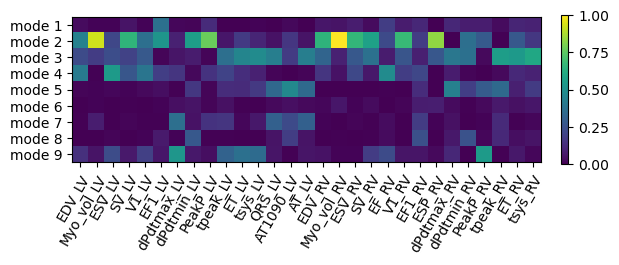

In [159]:
modes = ["mode 1", "mode 2", "mode 3", "mode 4",
              "mode 5", "mode 6", "mode 7", "mode 8", "mode 9"]
outputs = list(modelOutput.columns)

fig, ax = plt.subplots()
im = ax.imshow(SiZM_first/np.max(SiZM_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [160]:
SiZM_first[:,2]

array([6.71452682e-03, 1.67674572e-01, 1.87084022e-01, 4.27750970e-01,
       1.47650419e-02, 2.25479692e-03, 1.82155998e-04, 1.13335114e-02,
       1.81338492e-01])

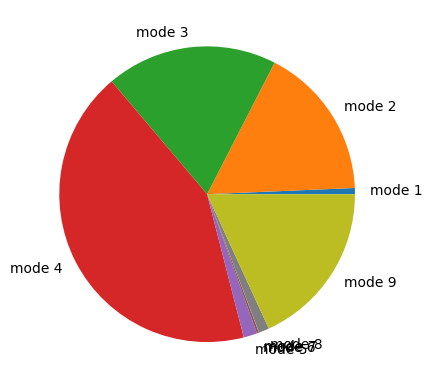

In [161]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,2]/np.max(SiZM_first[:,2]), labels=modes);


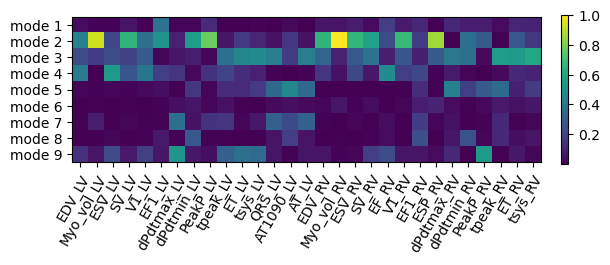

In [162]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total/np.max(SiZM_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

In [163]:
np.max(SiZM_total)

0.7879060655777113

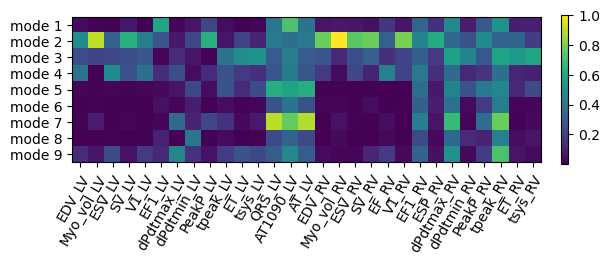

In [164]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total/np.max(Si_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [165]:
Si_first[:,2]

array([0.00375818, 0.24052493, 0.16254155, 0.38260271, 0.01264466,
       0.00084166, 0.00250641, 0.00792341, 0.18245212])

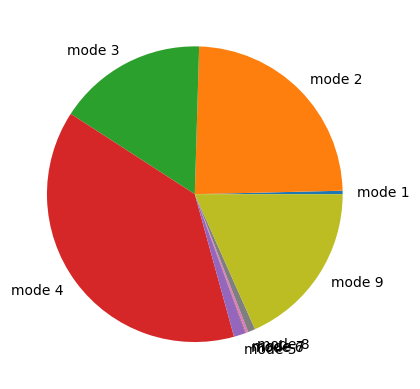

In [166]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,2]/np.max(Si_first[:,2]), labels=modes);


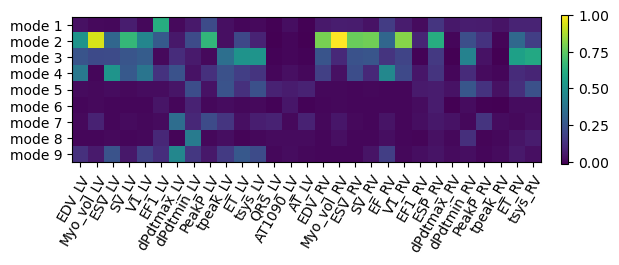

In [167]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Leave one out MSE

In [106]:
import random

In [ ]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [136]:
def EnsembleMSE(models,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        models[i].eval()
        
        MSE[i] = (((models[i](torch.tensor([modelInput.values])).mean-torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [178]:
def LREnsembleMSE(GPmodels,LRModel,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        
        MSE[i] = (((torch.tensor(y_predicted[:,i])+GPmodels[i](torch.tensor([modelInput.values])).mean-torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [179]:
modeWeightsOrig.shape

(51, 18)

In [180]:
GP_MSE = np.zeros(outputTestNorm.shape[1])
LRGP_MSE = np.zeros(outputTestNorm.shape[1])

for i in range(modeWeightsOrig.shape[0]):

    testIndices = [i]
    inputTest = modeWeightsOrig.iloc[testIndices,:]
    inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin(testIndices)]
    outputTest = modelOutputOrig.iloc[testIndices,:]
    outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin(testIndices)]
    
    outputTrainMean = np.mean(outputTrain,axis=0)
    outputTrainStd = np.std(outputTrain,axis=0)

    inputTrainMean = np.mean(inputTrain,axis=0)
    inputTrainStd = np.std(inputTrain,axis=0)
    
    inputTestNorm = standardise(inputTest,inputTrainMean,inputTrainStd)
    inputTrainNorm = standardise(inputTrain,inputTrainMean,inputTrainStd)
    outputTestNorm = standardise(outputTest,outputTrainMean,outputTrainStd)
    outputTrainNorm = standardise(outputTrain,outputTrainMean,outputTrainStd)
    
    models, likelihoods, MSE = GPEnsemble(inputTrainNorm,outputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(inputTrainNorm, outputTrainNorm)
    # Predict
    y_predicted = regression_model.predict(inputTrainNorm)
    modelOutputAdjusted = outputTrainNorm - y_predicted
    modelsZM, likelihoodsZM,MSEZM = GPEnsemble(inputTrainNorm,modelOutputAdjusted,zeroMean=True)
    LRGP_MSE+=LREnsembleMSE(modelsZM,regression_model,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28

In [181]:
GP_MSE

array([1.46977260e-03, 8.26116679e-03, 8.92871296e-04, 2.16495750e-03,
       2.38546502e-03, 2.34688404e-02, 1.23441489e-01, 7.50490753e-02,
       5.81696329e-02, 3.52786647e-01, 9.88658910e-02, 2.58355764e-01,
       2.14086691e-01, 1.83109972e-01, 2.09261251e-01, 2.21788304e-05,
       8.87228024e-02, 5.52223598e-05, 2.55793411e-05, 5.96548046e-04,
       6.30211761e-03, 3.29956517e-01, 1.76348454e-02, 7.10570656e-02,
       1.36430680e-01, 1.34162964e-01, 1.47366153e-01, 1.40131051e-01,
       2.73005454e-01])

In [182]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(modelOutput.columns)

In [183]:
dataset

,GP MSE,LRGP MSE
EDV_LV,0.001470,0.005311
Myo_vol_LV,0.008261,0.019893
ESV_LV,0.000893,0.000682
SV_LV,0.002165,0.001529
V1_LV,0.002385,0.002598
EF1_LV,0.023469,0.003324
dPdtmax_LV,0.123441,0.086199
dPdtmin_LV,0.075049,0.089633
PeakP_LV,0.058170,0.077303
tpeak_LV,0.352787,0.135879
